#Zadanie 2 (7 pkt)
Celem zadania jest rozwiązanie zadania optymalizacji przy pomocy algorytmu genetycznego. Należy znaleźć minimum zadanej funkcji:
\begin{equation}
f(x) = 1.5-\exp \left\{-x_1^2-x_2^2\right\}-0.5 \exp \left\{-\left(x_1-1\right)^2-\left(x_2+2\right)^2\right\}
\end{equation}
Należy wykorzystać mechanizmy krzyżowania punktowego, mutacji oraz selekcji turniejowej. Proszę wykorzystać przygotowany szkielet i zaimplementować niezbędne metody. Opracowane oprogramowanie powinno być uniwersalne - wymiar funkcji, której minimum szukamy może być dowolny (mechanizm *args). Punktacja wygląda następująco:

*   Stworzenie obiektu klasy *Chromosome* z polem *array*, które jest wektorem aktywnych i nieaktywnych genów - **0.5 pkt**
*   Implementacja metody *decode*, która dekoduje część chromosomu (określoną przez początek (*lower_bound*) i koniec (*upper_bound*)) do postaci liczby rzeczywistej. *aoi* to zakres wartości zdekodowanej liczby rzeczywistej. Przykład: liczba 135 w postaci binarnej zapisana przy użyciu 8 bitów to 1000 0111, jeśli nasze *aoi* to [0, 1], to 135 sprowadzone do tego zakresu to 0.529. Można skorzystać z funkcji pomocniczej *min_max_norm* - **1 pkt**
*   Implementacja metody *mutation*, która przyjmuje jako argument prawdopodobieństo mutacji i zmienia wartość jedego, losowego genu na przeciwną - **0.5 pkt**
*   Implementacja metody *crossover*, która wykonuje operację krzyżowania jednopunktowego - **1 pkt**
*   Implementacja metody *eval_objective_func*, która dekoduje cały chromosom (otrzymuje się argumenty funkcji) oraz zwraca wartość funkcji celu dla tych argumentów - **1 pkt**
*   Implementacja metody *tournament_selection*, która przeprowadza selekcję turniejową - **1 pkt**
*   Implementacja metody *reproduce*, która generuje nowe pokolenie - z pewnym prawdopodobieństwem przeprowadza krzyżowanie jednopunktowe lub "przerzuca" rodziców do nowego pokolenia - **0.5 pkt**
*   Implementacja metody *run*, która wykonuje cały alorytm genetyczny dla określonej liczby pokoleń. W każdym pokoleniu należy zapisać dane osobnika z najlepszym chromosomem zdekodowane wartości x i y oraz wartość funkcji strat dla tego osobnika - **0.5 pkt**
*   Proszę, podobnie jak miało to miejsce w przypadku metody gradientowej z poprzednich zajęć, wygenerować wykres przy użyciu funkcji *plot_func* (w przypadku innego typu argumentu *trace*, funkcję można zmodyfikować. Wykres powinien przedstawiać funkcję, której minimum poszukujemy oraz punkty odpowiadające najlepszym osobnikom w danych generacjach, których kolor jest coraz jaśniejszy wraz ze zbliżaniem się do minimum. Proszę zapisać swoje wnioski, w szczególności w odniesieniu do metody gradientowej. - **1 pkt**


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

import random

In [ ]:
def min_max_norm(val, min_val, max_val, new_min, new_max):
  return (val - min_val) * (new_max - new_min) / (max_val - min_val) + new_min

In [ ]:
class Chromosome:
  def __init__(self, length, array=None): #if array is None it should be initialized with random binary vector
    self.length = length
    if(array == None):
      array = [random.randint(0, 1) for i in range(self.length)]
    self.array = array

  def decode(self, lower_bound, upper_bound, aoi):
    max_value = 0
    value = 0
    for i in reversed(range(lower_bound, upper_bound)):
      max_value += aoi[1] * (2**(upper_bound - i - 1))
      value += self.array[i] * (2**(upper_bound - i - 1))
    val = min_max_norm(value, 0, max_value, -4, 1)
    return val

  def mutation(self, probability):
    index = random.randint(0, self.length - 1)
    num = random.normalvariate(0, 1)
    if(num < probability):
      self.array[index] = 1 if self.array[index] == 1 else 0
    
  def crossover(self, other):
    index = random.randint(0, self.length - 1)
    for i, sEl, oEl in zip(range(self.length), self.array, other.array):
      if(i >= index):
        temp = sEl
        sEl = oEl
        oEl = temp
    return self, other

In [ ]:
class GeneticAlgorithm:
  def __init__(self, chromosome_length, obj_func_num_args, objective_function, aoi, population_size=1000,
               tournament_size=2, mutation_probability=0.05, crossover_probability=0.8, num_steps=30):
    assert chromosome_length % obj_func_num_args == 0, "Number of bits for each argument should be equal"
    self.chromosome_lengths = chromosome_length
    self.obj_func_num_args = obj_func_num_args
    self.bits_per_arg = int(chromosome_length / obj_func_num_args)
    self.objective_function = objective_function
    self.aoi = aoi
    self.tournament_size = tournament_size
    self.mutation_probability = mutation_probability
    self.crossover_probability = crossover_probability
    self.num_steps = num_steps
    self.population_size = population_size

  def eval_objective_func(self, chromosome):
    x1 = chromosome.decode(0, self.bits_per_arg, self.aoi)
    x2 = chromosome.decode(self.bits_per_arg, self.chromosome_lengths, self.aoi)
    #value = self.objective_function(x1, x2)
    value = 1.5 - np.exp(- x1 ** (2) - x2 ** (2)) - 0.5 * np.exp(-(x1 - 1) ** (2) - (x2 + 2) ** (2))
    return value

  def tournament_selection(self, chromosomes):
    selected = np.random.randint(0, len(chromosomes) - 1)
    for i in np.random.randint(0, len(chromosomes) - 1, self.tournament_size - 1):
      if(self.eval_objective_func(chromosomes[i]) <= self.eval_objective_func(chromosomes[selected])):
        selected = i
    return chromosomes[selected]

  def reproduce(self, parents):
    num = random.normalvariate(0, 1)
    if(num < self.crossover_probability):
      parents[0].crossover(parents[1])
    return parents
    

  def plot_func(self, trace):
    X = np.arange(-2, 3, 0.05)
    Y = np.arange(-4, 2, 0.05)
    X, Y = np.meshgrid(X, Y)
    Z = 1.5 - np.exp(-X ** (2) - Y ** (2)) - 0.5 * np.exp(-(X - 1) ** (2) - (Y + 2) ** (2))
    plt.figure()
    plt.contour(X, Y, Z, 10)
    cmaps = [[ii / len(trace), 0, 0] for ii in range(len(trace))]
    plt.scatter([x[0] for x in trace], [x[1] for x in trace], c=cmaps)
    plt.show()

  def run(self):
    #reproduction and crossover
    #mutation
    #evaluate objective function
    #generate population
    trace = []
    generation = []
    for i in range(0, self.population_size):
        ch = Chromosome(self.chromosome_lengths)
        generation.append(ch)
    the_best = generation[0]
    the_best_value = self.eval_objective_func(generation[0])
    x1 = the_best.decode(0, self.bits_per_arg, self.aoi)
    x2 = the_best.decode(self.bits_per_arg, self.chromosome_lengths, self.aoi)
    print(f"x1: {x1}, x2: {x2}")
    print(the_best.array, the_best_value)
    trace.append((x1, x2))

    step = 0
    while(step != self.num_steps):
      for i in range(0, len(generation)):
        value = self.eval_objective_func(generation[i])
        if(value <= the_best_value):
          the_best = generation[i]
          the_best_value = value
          x1 = the_best.decode(0, self.bits_per_arg, self.aoi)
          x2 = the_best.decode(self.bits_per_arg, self.chromosome_lengths, self.aoi)
          print(f"x1: {x1}, x2: {x2}")
          print(the_best.array, the_best_value)
          trace.append((x1, x2))
      selected = []
      #new_generation = generation;
      #reproduction
      for i in range(0, len(generation)): #/ self.tournament_size
        selected.append(self.tournament_selection(generation))
        #mutation and crossover
      children = []
      for i in range(0, int(len(selected) / 2)):
        parents = random.sample(selected, 2)
        for j in self.reproduce(parents):
          j.mutation(self.mutation_probability)
          children.append(j)
      generation = children
      step += 1
    self.plot_func(trace)
    return (the_best.array, the_best_value, x1, x2)

Strumieniowane dane wyjściowe obcięte do 5000 ostatnich wierszy.
x1: -0.0588235294117645, x2: 0.117647058823529
[1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0] 0.5153135106503067
x1: -0.0588235294117645, x2: 0.117647058823529
[1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0] 0.5153135106503067
x1: -0.0588235294117645, x2: 0.117647058823529
[1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0] 0.5153135106503067
x1: -0.0588235294117645, x2: 0.117647058823529
[1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0] 0.5153135106503067
x1: -0.0588235294117645, x2: 0.117647058823529
[1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0] 0.5153135106503067
x1: -0.0588235294117645, x2: 0.117647058823529
[1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0] 0.5153135106503067
x1: -0.0588235294117645, x2: 0.117647058823529
[1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0] 0.5153135106503067
x1: -0.0588235294117645, x2: 0.117647058823529
[1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0] 0.5153135106503067
x1: -0.05882352

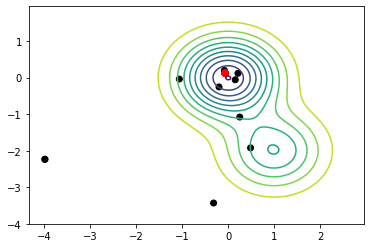

In [ ]:
  def objectiveFunction(x1, x2):
    return 1.5 - np.exp(- x1 ** (2) - x2 ** (2)) - 0.5 * np.exp(-(x1 - 1) ** (2) - (x2 + 2) ** (2))
  
  def main():
    length = 8
    arr =  [1, 0, 0, 0, 0, 1, 1, 1]
    #arr2 = [0, 0, 0, 1, 1, 0, 1, 1]
    aoi = [0, 1]
    #ch = Chromosome(length, arr)
    #ch2 = Chromosome(length, arr2)
    #ch.crossover(ch2)
    #print(ch.decode(0, length, aoi))
    #print(ch2.array)
 
    chLength = 16
    numArgs = 2
    aoi = [0, 1]
    num_steps = 50

    Gen = GeneticAlgorithm(chLength, numArgs, objectiveFunction, aoi, population_size=1000, tournament_size = 3, num_steps = 50)
    Gen.run()

  if __name__ == "__main__":
    main()